In [1]:
import pandas as pd
import numpy as np
import polars as pl
import datetime
import sqlite3
import pickle
import time
import logging
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from mapie.regression import MapieQuantileRegressor

# import warnings
# warnings.filterwarnings('ignore')

PROJ_ROOT = str(Path(os.getcwd()).parent) # add project root file to the python paths
sys.path.append(PROJ_ROOT)


In [2]:
PROJ_ROOT

'/home/miroslav/Documents/projects/applied_qf/conformal-op'

In [26]:
# load predictions

df = pl.read_parquet(f"{PROJ_ROOT}/run_real2/results/pis_2000parquet")

In [27]:
df

lb,ub
f64,f64
0.01347,0.01576
0.029238,0.034815
0.001295,0.002182
0.019333,0.022825
0.042044,0.046749
…,…
0.231197,0.246737
0.134966,0.14237
0.108271,0.113029


In [28]:
# load test data

df_test = pl.read_parquet(f"{PROJ_ROOT}/data/processed/real_walk_fwd/sample_data_2000.parquet")

In [29]:
df_test

S,sigma,tau,r,cp_flag,V
f64,f64,f64,f64,bool,f64
1.121667,0.572145,0.052055,5.925314,false,0.014167
1.0515625,0.564826,0.052055,5.925314,false,0.030469
0.84125,0.452223,0.052055,5.925314,true,0.001875
0.934722,0.523723,0.052055,5.925314,true,0.020833
0.989706,0.54661,0.052055,5.925314,true,0.044853
…,…,…,…,…,…
1.173229,0.538585,0.309589,6.218447,true,0.246429
1.026575,0.531451,0.309589,6.218447,true,0.1421875
0.912511,0.495321,0.558904,6.020147,true,0.1125


In [30]:
# load dates and secids

dates_secids = pl.read_parquet(f"{PROJ_ROOT}/data/processed/real_walk_fwd/sample_data_2000_dates_secids.parquet")

In [32]:
results_df = pl.concat([dates_secids, df_test, df], how='horizontal')

In [33]:
results_df

secid,date,S,sigma,tau,r,cp_flag,V,lb,ub
i32,date,f64,f64,f64,f64,bool,f64,f64,f64
5067,2000-01-03,1.121667,0.572145,0.052055,5.925314,false,0.014167,0.01347,0.01576
5067,2000-01-03,1.0515625,0.564826,0.052055,5.925314,false,0.030469,0.029238,0.034815
5067,2000-01-03,0.84125,0.452223,0.052055,5.925314,true,0.001875,0.001295,0.002182
5067,2000-01-03,0.934722,0.523723,0.052055,5.925314,true,0.020833,0.019333,0.022825
5067,2000-01-03,0.989706,0.54661,0.052055,5.925314,true,0.044853,0.042044,0.046749
…,…,…,…,…,…,…,…,…,…
112507,2000-12-29,1.173229,0.538585,0.309589,6.218447,true,0.246429,0.231197,0.246737
112507,2000-12-29,1.026575,0.531451,0.309589,6.218447,true,0.1421875,0.134966,0.14237
112507,2000-12-29,0.912511,0.495321,0.558904,6.020147,true,0.1125,0.108271,0.113029


In [3]:
first = True

for year in range(2000, 2023):
    df = pl.read_parquet(f"{PROJ_ROOT}/run_real2/results/pis_{year}parquet")
    df_test = pl.read_parquet(f"{PROJ_ROOT}/data/processed/real_walk_fwd/sample_data_{year}.parquet")
    dates_secids = pl.read_parquet(f"{PROJ_ROOT}/data/processed/real_walk_fwd/sample_data_{year}_dates_secids.parquet")

    # check if the data is the same length
    if len(df) != len(df_test):
        print(f"Year {year} has different lengths: {len(df)} vs {len(df_test)}")
        continue
    if len(df) != len(dates_secids):
        print(f"Year {year} has different lengths: {len(df)} vs {len(dates_secids)}")
        continue
    
    results_df = pl.concat([dates_secids, df_test, df], how='horizontal')
    results_df = results_df.with_columns(
    covered = (results_df["V"] >= results_df["lb"]) & (results_df["V"] <= results_df["ub"])
        )
    # group by date, and average the covered column
    if first:
        result = results_df.group_by("date").agg(pl.col("covered").mean().alias("average_coverage"))
        first = False
    else:
        result = pl.concat([result, results_df.group_by("date").agg(pl.col("covered").mean().alias("average_coverage"))], how='vertical')

In [4]:
# sort by date
result = result.sort("date")

In [5]:
result

date,average_coverage
date,f64
2000-01-03,0.898399
2000-01-04,0.905969
2000-01-05,0.905278
2000-01-06,0.904071
2000-01-07,0.903527
…,…
2022-12-23,0.691367
2022-12-27,0.683706
2022-12-28,0.666126


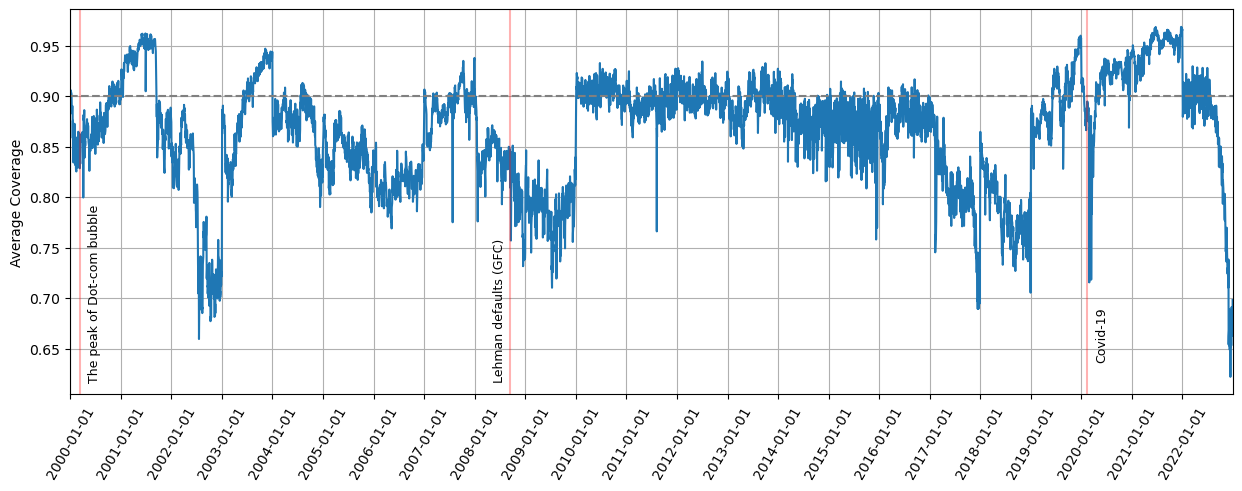

In [54]:
# plot the average coverage

plt.figure(figsize=(15, 5))
plt.plot(result["date"].to_numpy(), result["average_coverage"].to_numpy(), )

# add a horizontal line at 0.9- 
plt.axhline(y=0.9, color='gray', linestyle='--')

# add yaxis title
plt.ylabel("Average Coverage")

# add vertical line at 2020 to show the start of the covid pandemic
plt.axvline(x=datetime.datetime(2020, 2, 12), color='red', linestyle='-', alpha=0.3)

# add text to the vertical line
plt.text(datetime.datetime(2020, 4, 12), 0.64, 'Covid-19', rotation=90, size=9)


# add vertical line at 2020 to show the start of the covid pandemic
plt.axvline(x=datetime.datetime(2008, 9, 15), color='red', linestyle='-', alpha=0.3)

# add text to the vertical line
plt.text(datetime.datetime(2008, 5, 15), 0.62, 'Lehman defaults (GFC)', rotation=90, size=9)


# add vertical line at 2020 to show the start of the covid pandemic
plt.axvline(x=datetime.datetime(2000, 3, 10), color='red', linestyle='-', alpha=0.3)

# add text to the vertical line
plt.text(datetime.datetime(2000, 5, 10), 0.62, 'The peak of Dot-com bubble ', rotation=90, size=9)

# set x limits
plt.xlim(datetime.datetime(2000, 1, 1), datetime.datetime(2022, 12, 31))

# set x tickers to be every year, but use the first day of the year

plt.xticks(pd.date_range(start='2000-01-01', end='2022-01-01', freq='YS'))

# rotate x labels
plt.xticks(rotation=60)

# add grid lines
plt.grid()

# save the plot
plt.savefig(f"{PROJ_ROOT}/reports/figures/real_data_walk_fwd/average_coverage.png", dpi=400)


In [ ]:

pd.date_range(start='2000-01-01', end='2023-01-01', freq='Y', )

TypeError: DatetimeArray._generate_range() got an unexpected keyword argument 'closed'